In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
from sklearn.externals import joblib

import sys 
sys.path.append('..')
from algo import generateHeader

In [4]:
df = pd.read_csv("../benchres/bench_final.csv")
df_rules = pd.read_csv("../benchres/benchrules.csv")

In [6]:
def customized_box_plot(percentiles, axes, redraw = True, *args, **kwargs):
    """
    Generates a customized boxplot based on the given percentile values
    """
    n_box = len(percentiles)
    box_plot = axes.boxplot([[-9, -4, 2, 4, 9],]*n_box, *args, **kwargs) 
    # Creates len(percentiles) no of box plots

    min_y, max_y = float('inf'), -float('inf')

    for box_no, pdata in enumerate(percentiles):
        if len(pdata) == 6:
            (q1_start, q2_start, q3_start, q4_start, q4_end, fliers_xy) = pdata
        elif len(pdata) == 5:
            (q1_start, q2_start, q3_start, q4_start, q4_end) = pdata
            fliers_xy = None
        else:
            raise ValueError("Percentile arrays for customized_box_plot must have either 5 or 6 values")

        # Lower cap
        box_plot['caps'][2*box_no].set_ydata([q1_start, q1_start])
        # xdata is determined by the width of the box plot

        # Lower whiskers
        box_plot['whiskers'][2*box_no].set_ydata([q1_start, q2_start])

        # Higher cap
        box_plot['caps'][2*box_no + 1].set_ydata([q4_end, q4_end])

        # Higher whiskers
        box_plot['whiskers'][2*box_no + 1].set_ydata([q4_start, q4_end])

        # Box
        path = box_plot['boxes'][box_no].get_path()
        path.vertices[0][1] = q2_start
        path.vertices[1][1] = q2_start
        path.vertices[2][1] = q4_start
        path.vertices[3][1] = q4_start
        path.vertices[4][1] = q2_start

        # Median
        box_plot['medians'][box_no].set_ydata([q3_start, q3_start])

        # Outliers
        if fliers_xy is not None and len(fliers_xy[0]) != 0:
            # If outliers exist
            box_plot['fliers'][box_no].set(xdata = fliers_xy[0],
                                           ydata = fliers_xy[1])

            min_y = min(q1_start, min_y, fliers_xy[1].min())
            max_y = max(q4_end, max_y, fliers_xy[1].max())

        else:
            min_y = min(q1_start, min_y)
            max_y = max(q4_end, max_y)

        # The y axis is rescaled to fit the new box plot completely with 10% 
        # of the maximum value at both ends
        axes.set_ylim([min_y*1.1, max_y*1.1])

    # If redraw is set to true, the canvas is updated.
    if redraw:
        ax.figure.canvas.draw()

    return box_plot

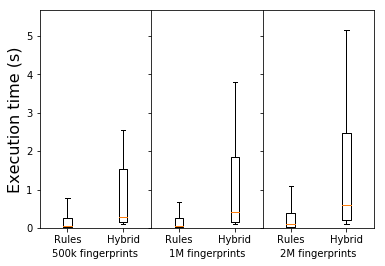

In [18]:
data = {}
data['dataset1'] = {"A":"", "B":""}
data['dataset2'] = {"A":"", "B":""}
data['dataset3'] = {"A":"", "B":""}

df_16p = df[df["nb_processes"] == 16].sort_values("nb_fingerprints")
percentiles = []
for index, row in df_16p.iterrows():

    percentiles.append([
        row["min"],
        row["q1"],
        row["median"],
        row["q3"],
        row["max"]/3
    ])
    

df_16p2 = df_rules[df_rules["nb_processes"] == 16].sort_values("nb_fingerprints")
for index, row in df_16p2.iterrows():

    percentiles.append([
        row["min"],
        row["q1"],
        row["median"],
        row["q3"],
        row["max"]/3
    ])

data["dataset1"]["A"] = percentiles[3]
data["dataset2"]["A"] = percentiles[4]
data["dataset3"]["A"] = percentiles[5]
data["dataset1"]["B"] = percentiles[0]
data["dataset2"]["B"] = percentiles[1]
data["dataset3"]["B"] = percentiles[2]


fig, axes = plt.subplots(ncols=3, sharey=True)
fig.subplots_adjust(wspace=0)
name_to_label = {
    "dataset1": "500k fingerprints",
    "dataset2": "1M fingerprints",
    "dataset3": "2M fingerprints"
    
}

name_to_algo = {
    "A": "Rules",
    "B": "Hybrid"
}

axes[0].set_ylabel('Execution time (s)', fontsize=16)

for ax, name in zip(axes, ['dataset1', 'dataset2', 'dataset3']):
    customized_box_plot([data[name][item] for item in ['A', 'B']], ax)
    ax.set(xticklabels=['Rules', 'Hybrid'], xlabel=name_to_label[name])
    ax.margins(0.05) # Optional

plt.savefig("./benchmark_bp_all.pdf")
plt.show()

29.974860999999997
[1.0, 2.0, 4.0, 8.0, 16.0]
[0.0, 42.9766830278212, 70.53711775344013, 88.07669533480072, 93.68304993974785]


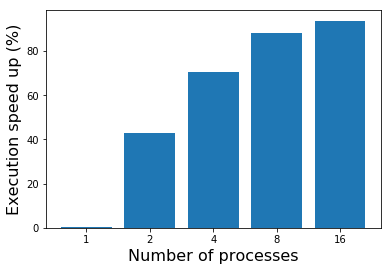

In [40]:
df_c = df[df["nb_fingerprints"] == 2000000].sort_values("nb_processes")
ref_exec_time = float(df_c[df_c["nb_processes"] == 1]["avg"])
print(ref_exec_time)
speed_ups = []
processes = []
for index, row in df_c.iterrows():
    speed_ups.append(100*(ref_exec_time - row["avg"])/ref_exec_time)
    processes.append(row["nb_processes"])
    if row["nb_processes"] > 15:
        break
   
with open("./parallel_gain.csv", "w+") as f:
    f.write("num_proc,speed_up\n")
    for idx in range(len(speed_ups)):
        f.write("{:d},{:f}\n".format(int(processes[idx]), speed_ups[idx]))
print(processes)
print(speed_ups)
speed_ups[0] = 0.5
x_pos = np.arange(len(speed_ups))

plt.bar(x_pos, speed_ups)
plt.xticks(x_pos, ["{:.0f}".format(x) for x in processes])
plt.ylabel('Execution speed up (%)', fontsize=16)
plt.xlabel('Number of processes', fontsize=16)
plt.savefig("./avg_exec_time_proc.pdf")
plt.show()